In [1]:
import pandas as pd
import numpy as np

import rpy2.robjects as robjects
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri

import statsmodels.formula.api as smf
import statsmodels.api as sm

import patsy
#from sklearn.linear_model import RidgeCV

#import sklearn

import tensorflow as tf
#from tensorflow import keras
import tensorflow.keras as keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

import os

#from keras.preprocessing import image as image_utils
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input

#from scipy import sparse
#from itertools import chain

import glmnet_python
from glmnet import glmnet; from glmnetPlot import glmnetPlot
from glmnetPredict import glmnetPredict

from cvglmnet import cvglmnet
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

2022-12-10 17:48:33.731179: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 10.9.1 A Single Layer Network on the Hitters Data

In [2]:
Gitters = pd.read_csv('/Users/rancher/Google Drive/Coding/ISLR2/datasets/Hitters.csv')

Gitters = Gitters.dropna()

# R starts indexing at 1, Python starts indexing at 0, this is to make sure the indices of the dataframes match
Gitters = Gitters.set_index(keys=np.arange(1,264)) 

n = Gitters.shape[0]
ntest = n // 3

data = robjects.r("""
library(ISLR2)
n <- nrow(na.omit(Hitters))
set.seed(13)
ntest <- trunc(n / 3)
testid <- sample(1:n, ntest)
""")

testid = np.sort(np.array(data))
test_mask = Gitters.index.isin(testid)

In [3]:
def formula_from_cols(df, y):
    return y + ' ~ ' + ' + '.join([col for col in df.columns if not col==y])

In [4]:
formula_string = formula_from_cols(Gitters, 'Salary')

lmodel = smf.ols(formula=formula_string, data = sm.add_constant(Gitters[~test_mask]))

lfit = lmodel.fit()

lpred = lfit.predict(Gitters[test_mask])

np.mean(abs(lpred - Gitters[test_mask]['Salary']))

254.6686528837497

In [5]:
x = patsy.dmatrix(formula_like = 'AtBat + Hits + HmRun + Runs + RBI + Walks + Years + CAtBat + CHits + CHmRun + CRuns + CRBI + CWalks + League + Division + PutOuts + Assists + Errors + NewLeague - 1', data = Gitters)

x_scale = patsy.scale(x, ddof=1)

y = np.array(Gitters['Salary'])

In [6]:
x.design_info.column_names

['League[A]',
 'League[N]',
 'Division[T.W]',
 'NewLeague[T.N]',
 'AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'Errors']

In [7]:
x_scale.shape

(263, 20)

In [8]:
x_scale[~test_mask].shape

(176, 20)

In [9]:
y[~test_mask].shape

(176,)

In [10]:
x_scale.tolist()[4]

[0.9427058754986926,
 -0.9427058754986926,
 0.9792988113777307,
 -0.9284170990118696,
 1.2922477864706194,
 1.355582511837019,
 -0.8701242575199089,
 0.753911192775226,
 -0.018803747162034392,
 -0.2815200590374653,
 0.7694010081772826,
 0.7655336927472222,
 0.6337764794940891,
 -0.6112046464962497,
 0.4220412770176512,
 0.017261308407232237,
 -0.2509550732807127,
 -0.031118080360665493,
 2.083252981719132,
 2.4834117511926994]

In [16]:
X_train = x_scale[~test_mask]
X_test = x_scale[test_mask]

y_train = Gitters[~test_mask]['Salary']
y_test = Gitters[test_mask]['Salary']

# Old code that was from before I discovered the cvglmnet module for Python that more closely mimics the cv.glmnet function from R

# ridge_cv = RidgeCV(scoring='neg_mean_absolute_error').fit(X_train, y_train)

# rpred = ridge_cv.predict(X_test)

# np.mean(abs(y_test - rpred))


cvfit = cvglmnet(x = x_scale[~test_mask], y = y[~test_mask], ptype='mae')

cpred = cvglmnetPredict(cvfit, newx = x_scale[test_mask], s = 'lambda_min')

In [17]:
np.mean(abs(y[test_mask] - cpred))

427.2936419595149

I'm getting a much higher MAE than the ISLR textbook does (they get 252.2994) and I'm not entirely sure why.  As far as I can tell, the inputs, `x_scale` and `y` are the same as in the textbook, however the predictions (`cpred`) are slightly different, leading to a different MAE.  I need to investigate further.

In [18]:
modnn = keras.Sequential(
    [
            layers.Dense(units = 50, activation='relu'),
            layers.Dropout(rate=0.4),
            layers.Dense(units=1)
    ]
)

In [19]:
modnn.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='rmsprop', metrics=tf.keras.losses.MeanAbsoluteError())

In [20]:
history = modnn.fit(X_train, y_train, epochs=1500, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/1500
6/6 [==============================] - 1s 38ms/step - loss: 457440.5000 - mean_absolute_error: 542.7205 - val_loss: 556194.2500 - val_mean_absolute_error: 534.3148
Epoch 2/1500
6/6 [==============================] - 0s 7ms/step - loss: 456982.1250 - mean_absolute_error: 530.3832 - val_loss: 555888.7500 - val_mean_absolute_error: 534.0609
Epoch 3/1500
6/6 [==============================] - 0s 7ms/step - loss: 456716.9062 - mean_absolute_error: 521.0688 - val_loss: 555605.4375 - val_mean_absolute_error: 533.8422
Epoch 4/1500
6/6 [==============================] - 0s 7ms/step - loss: 456477.3750 - mean_absolute_error: 528.3708 - val_loss: 555325.3125 - val_mean_absolute_error: 533.6243
Epoch 5/1500
6/6 [==============================] - 0s 7ms/step - loss: 456189.3125 - mean_absolute_error: 532.8423 - val_loss: 555039.2500 - val_mean_absolute_error: 533.4019
Epoch 6/1500
6/6 [==============================] - 0s 7ms/step - loss: 455921.3750 - mean_absolute_error: 518.3868 - v

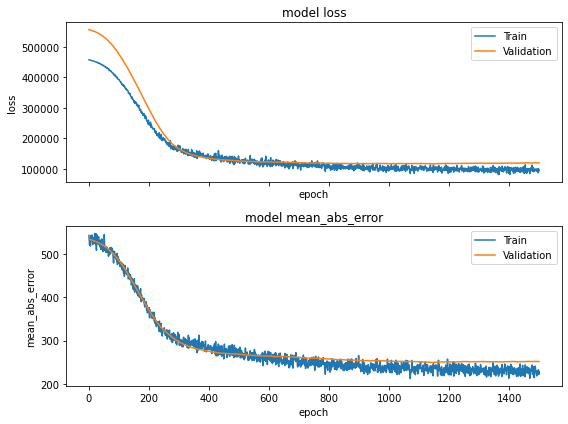

In [21]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize=(8,6))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['Train', 'Validation'])

ax[1].plot(history.history['mean_absolute_error'])
ax[1].plot(history.history['val_mean_absolute_error'])
ax[1].set_title('model mean_abs_error')
ax[1].set_ylabel('mean_abs_error')
ax[1].set_xlabel('epoch')
ax[1].legend(['Train', 'Validation'])
plt.tight_layout();

In [22]:
npred = modnn.predict(X_test)

3/3 [==============================] - 0s 1ms/step


In [23]:
np.mean(abs(y_test - npred.flatten()))

256.9490883648752

# 10.9.2 A Multilayer Network on the MNIST Digit Data

In [24]:
(x_train, g_train), (x_test, g_test) = keras.datasets.mnist.load_data()

In [25]:
x_train.shape

(60000, 28, 28)

In [26]:
x_test.shape

(10000, 28, 28)

In [27]:
x_train = np.reshape(x_train, newshape=(x_train.shape[0], 784))
x_test = np.reshape(x_test, newshape=(x_test.shape[0], 784))

In [28]:
# y_train = pd.get_dummies(g_train)
# y_test = pd.get_dummies(g_test)

y_train = keras.utils.to_categorical(g_train)
y_test = keras.utils.to_categorical(g_test)

In [29]:
x_train = x_train / 255
x_test = x_test / 255

In [30]:
modelnn = keras.Sequential(
    [
            layers.Dense(units=256, activation='relu'),
            layers.Dropout(rate=0.4),
            layers.Dense(units=128, activation='relu'),
            layers.Dropout(rate=0.3),
            layers.Dense(units=10, activation='softmax')
    ]
)

In [31]:
modelnn.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics='accuracy')

In [32]:
history = modelnn.fit(x_train, y_train, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
375/375 [==============================] - 3s 5ms/step - loss: 0.4429 - accuracy: 0.8663 - val_loss: 0.1603 - val_accuracy: 0.9523
Epoch 2/30
375/375 [==============================] - 1s 4ms/step - loss: 0.2021 - accuracy: 0.9409 - val_loss: 0.1226 - val_accuracy: 0.9641
Epoch 3/30
375/375 [==============================] - 1s 4ms/step - loss: 0.1556 - accuracy: 0.9538 - val_loss: 0.1066 - val_accuracy: 0.9693
Epoch 4/30
375/375 [==============================] - 1s 4ms/step - loss: 0.1334 - accuracy: 0.9601 - val_loss: 0.0970 - val_accuracy: 0.9712
Epoch 5/30
375/375 [==============================] - 1s 3ms/step - loss: 0.1150 - accuracy: 0.9657 - val_loss: 0.0888 - val_accuracy: 0.9761
Epoch 6/30
375/375 [==============================] - 1s 4ms/step - loss: 0.1051 - accuracy: 0.9693 - val_loss: 0.0910 - val_accuracy: 0.9758
Epoch 7/30
375/375 [==============================] - 1s 3ms/step - loss: 0.0976 - accuracy: 0.9716 - val_loss: 0.0930 - val_accuracy: 0.9763
Epoch 

In [33]:
modelnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               200960    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


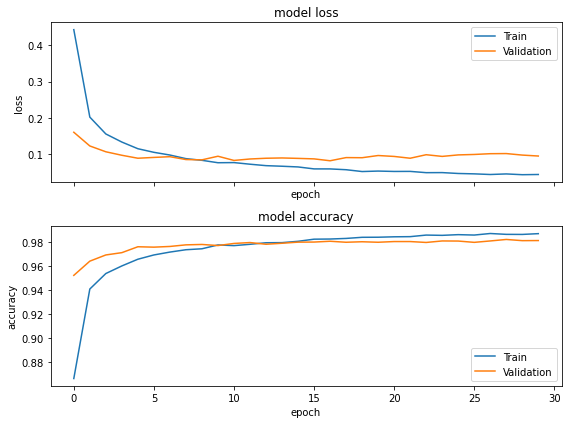

In [34]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize=(8,6))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['Train', 'Validation'])

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['Train', 'Validation'])
plt.tight_layout();

In [35]:
y_proba = modelnn.predict(x_test)
y_pred_classes = np.argmax(y_proba, axis=1)

313/313 [==============================] - 0s 1ms/step


In [36]:
modelnn_acc = np.mean(y_pred_classes == g_test)
modelnn_acc

0.9826

## Multiclass Logistic Regression

In [37]:
modellr = keras.models.Sequential(
    [
            layers.Dense(units=10, activation='softmax')
    ]
)

In [38]:
modellr.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics='accuracy')

In [39]:
modellr.fit(x_train, y_train, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
375/375 [==============================] - 1s 2ms/step - loss: 0.6746 - accuracy: 0.8340 - val_loss: 0.3591 - val_accuracy: 0.9038
Epoch 2/30
375/375 [==============================] - 1s 2ms/step - loss: 0.3531 - accuracy: 0.9027 - val_loss: 0.3098 - val_accuracy: 0.9137
Epoch 3/30
375/375 [==============================] - 1s 2ms/step - loss: 0.3174 - accuracy: 0.9121 - val_loss: 0.2925 - val_accuracy: 0.9209
Epoch 4/30
375/375 [==============================] - 1s 2ms/step - loss: 0.3013 - accuracy: 0.9158 - val_loss: 0.2840 - val_accuracy: 0.9203
Epoch 5/30
375/375 [==============================] - 1s 2ms/step - loss: 0.2921 - accuracy: 0.9193 - val_loss: 0.2768 - val_accuracy: 0.9234
Epoch 6/30
375/375 [==============================] - 1s 1ms/step - loss: 0.2852 - accuracy: 0.9201 - val_loss: 0.2742 - val_accuracy: 0.9265
Epoch 7/30
375/375 [==============================] - 1s 1ms/step - loss: 0.2798 - accuracy: 0.9216 - val_loss: 0.2735 - val_accuracy: 0.9257
Epoch 

In [40]:
y_proba = modellr.predict(x_test)
y_pred_classes = np.argmax(y_proba, axis=1)

313/313 [==============================] - 0s 819us/step


In [41]:
modellr_acc = np.mean(y_pred_classes == g_test)
modellr_acc

0.9271

# 10.9.3 Convolutional Neural Networks

In [42]:
(x_train, g_train), (x_test, g_test) = keras.datasets.cifar100.load_data()

x_train.shape

(50000, 32, 32, 3)

In [43]:
x_train[0, :, :, 0].min(), x_train[0, :, :, 0].max()

(13, 255)

In [44]:
x_train = x_train / 255
x_test = x_test / 255
y_train = keras.utils.to_categorical(g_train, num_classes=100)

y_train.shape

(50000, 100)

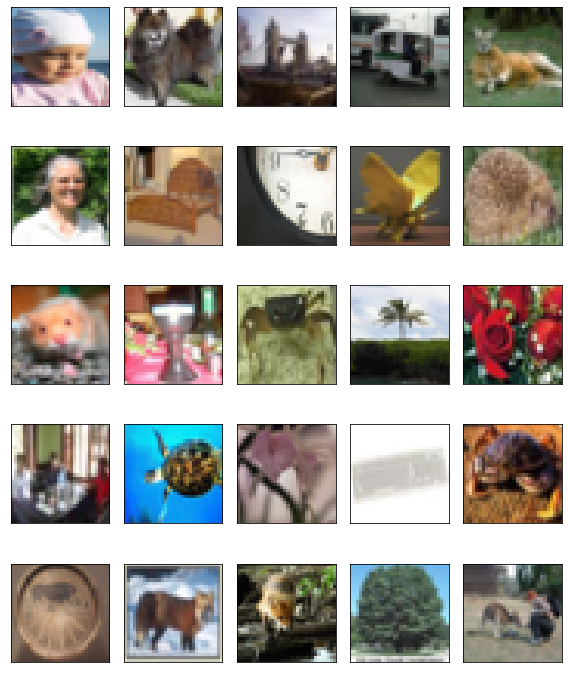

In [45]:
# Code taken from https://www.binarystudy.com/2021/09/how-to-load-preprocess-visualize-CIFAR-10-and-CIFAR-100.html#cifar100-single
rows, columns = 5,5
rand_idx = np.random.randint(0, 50000, rows * columns)
rand_images = x_train[rand_idx]
fig = plt.figure(figsize=(8,10))
for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(rand_images[i-1])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [46]:
model = keras.models.Sequential(
    [
        layers.Conv2D(filters=32, kernel_size=(3,3),
                     padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(filters=64, kernel_size=(3,3),
                     padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(filters=128, kernel_size=(3,3),
                     padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.Dropout(rate=0.5),
        layers.Dense(units=512, activation='relu'),
        layers.Dense(units=100, activation='softmax')
    ]
)

In [47]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics='accuracy')

history = model.fit(x_train, y_train, epochs=30, batch_size=128, validation_split=0.2)

y_proba = model.predict(x_test)
y_pred_classes = np.argmax(y_proba, axis=-1)

np.mean(y_pred_classes == g_test.flatten())

Epoch 1/30
313/313 [==============================] - 39s 123ms/step - loss: 4.0754 - accuracy: 0.0782 - val_loss: 3.6454 - val_accuracy: 0.1420
Epoch 2/30
313/313 [==============================] - 36s 116ms/step - loss: 3.4235 - accuracy: 0.1834 - val_loss: 3.2531 - val_accuracy: 0.2181
Epoch 3/30
313/313 [==============================] - 37s 118ms/step - loss: 3.0791 - accuracy: 0.2500 - val_loss: 2.9523 - val_accuracy: 0.2723
Epoch 4/30
313/313 [==============================] - 35s 112ms/step - loss: 2.8368 - accuracy: 0.2940 - val_loss: 2.9266 - val_accuracy: 0.2773
Epoch 5/30
313/313 [==============================] - 36s 114ms/step - loss: 2.6457 - accuracy: 0.3326 - val_loss: 2.6443 - val_accuracy: 0.3417
Epoch 6/30
313/313 [==============================] - 35s 112ms/step - loss: 2.4833 - accuracy: 0.3668 - val_loss: 2.5306 - val_accuracy: 0.3637
Epoch 7/30
313/313 [==============================] - 35s 112ms/step - loss: 2.3391 - accuracy: 0.3945 - val_loss: 2.4784 - val_ac

0.4178

In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)       

# 10.9.4 Using Pretrained CNN Models

In [49]:
img_dir = '/Users/rancher/Google Drive/Coding/ISLR2/Python/chp10/labs/book_images'

image_names = os.listdir(img_dir)

num_images = len(image_names)

x = []
for img_name in image_names:
    if not img_name.startswith('.'):
        img_path = img_dir + '/' + img_name
        img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        x.append(keras.preprocessing.image.img_to_array(img))

x = np.array(x)

x = preprocess_input(x)

In [50]:
model = keras.applications.resnet50.ResNet50(weights='imagenet')

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [51]:
pred6 = model.predict(x)
keras.applications.imagenet_utils.decode_predictions(pred6, top=3)

1/1 [==============================] - 2s 2s/step


[[('n01843065', 'jacamar', 0.48659828),
  ('n01818515', 'macaw', 0.2302896),
  ('n02494079', 'squirrel_monkey', 0.04457093)],
 [('n02007558', 'flamingo', 0.93010926),
  ('n02006656', 'spoonbill', 0.06801473),
  ('n02002556', 'white_stork', 0.0011723739)],
 [('n02097474', 'Tibetan_terrier', 0.5246219),
  ('n02098413', 'Lhasa', 0.40590084),
  ('n02094114', 'Norfolk_terrier', 0.016995287)],
 [('n01608432', 'kite', 0.7243432),
  ('n01622779', 'great_grey_owl', 0.08683513),
  ('n01532829', 'house_finch', 0.039976306)],
 [('n03388043', 'fountain', 0.27721667),
  ('n03532672', 'hook', 0.17947064),
  ('n03804744', 'nail', 0.11035818)],
 [('n02105641', 'Old_English_sheepdog', 0.8390029),
  ('n02086240', 'Shih-Tzu', 0.042358067),
  ('n03223299', 'doormat', 0.032265674)]]

# 10.9.5 IMDb Document Classification

In [52]:
max_features = 10_000
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)

In [53]:
x_train[0][0:12]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468]

In [54]:
word_index = keras.datasets.imdb.get_word_index()

def decode_review(text: list, word_index: dict):
    new_strings = ["<PAD>", "<START>", "<UNK>", "<UNUSED>"]
    
    idx = list(word_index.values())
    idx_plus_3 = np.array(idx) + 3
    new_idx = np.append(np.arange(0,4), idx_plus_3)
    new_idx = list(new_idx)
    
    word = list(word_index.keys())
    word = new_strings + word
    
    words = []
    
    for word_val in text:
        if word_val not in new_idx:
            word_val = 2 #use idx 2 to return "<UNK>" when idx of word can't be found
        words.append(word[new_idx.index(word_val)])

    print(" ".join(words))
    
decode_review(x_train[0][0:12], word_index)

<START> this film was just brilliant casting location scenery story direction everyone's


In [55]:
def one_hot(sequences, dimension):
    from scipy import sparse
    from itertools import chain
    
    seqlen = np.array([], dtype=np.int64)
    for seq in sequences:
        seqlen = np.append(seqlen, len(seq))
    
    n = len(seqlen)
    
    rowind = np.repeat(np.arange(0, n), repeats=seqlen)
    
    # Because R starts indexing at 1 and word_index has a minimum value of 1, everything matches up nicely in R.  However, Python starts indexing at 0 and we need to adjust the values of word_index accordingly.  By subtracting 1 from colind, the first word in our dataset will be in the first column (column 0), just like in R where the first word is in the first column (column 1).
    colind = np.array(list(chain(*sequences))) - 1  #taken from https://stackoverflow.com/questions/52573275/get-all-items-in-a-python-list
    
    sparse_array = np.zeros(shape=(n, dimension))
    sparse_array[rowind, colind] = 1
    
    sparse_matrix = sparse.coo_matrix(sparse_array)
        
    return sparse_matrix

In [56]:
x_train_1h = one_hot(x_train, 10000)
x_test_1h = one_hot(x_test, 10000)

x_train_1h.shape

(25000, 10000)

In [57]:
x_train_1h.count_nonzero() / (25000 * 10000)

0.013169872

In [58]:
data = robjects.r("""
set.seed(3)
ival <- sample(seq(1:25000), 2000)
""")

ival = np.sort(np.array(data) - 1)
ival_mask = pd.DataFrame(x_train_1h.toarray()).index.isin(ival)

In [59]:
fitlm = glmnet(x=x_train_1h.tocsr()[~ival_mask].toarray(),
               y=y_train[~ival_mask].astype(np.float64), 
               family='binomial', 
               standardize=True)

classlmv = glmnetPredict(fitlm, x_train_1h.tocsr()[ival_mask]) > 0

acclmv = []
for i in range(100):
    acc = np.mean(np.array(classlmv[:, i]).flatten() == (y_train[ival_mask] > 0))
    acclmv.append(acc)

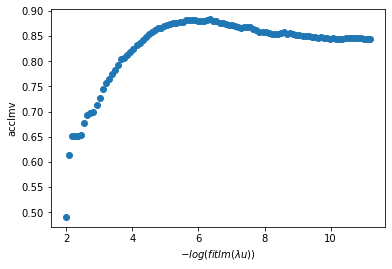

In [60]:
plt.scatter(-np.log(fitlm['lambdau']), acclmv)
plt.xlabel("$-log(fitlm(\lambda u))$")
plt.ylabel("acclmv");

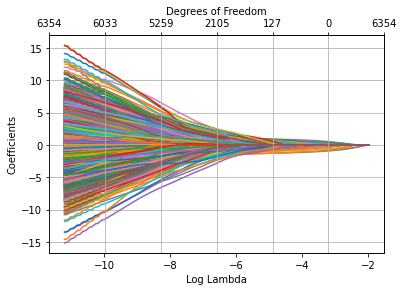

In [61]:
glmnetPlot(fitlm, xvar='lambda');

In [62]:
model = keras.models.Sequential(
    [
        layers.Dense(units=16, activation='relu'),
        layers.Dense(units=16, activation='relu'),
        layers.Dense(units=1, activation='sigmoid')
    ]
)

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics='accuracy')

history = model.fit(x=x_train_1h.tocsr()[~ival_mask], 
                    y=y_train[~ival_mask], 
                    epochs=20, batch_size=512, 
                    validation_data=(
                        x_train_1h.tocsr()[ival_mask], y_train[ival_mask]
                    )
                   )

Epoch 1/20
45/45 [==============================] - 1s 13ms/step - loss: 0.5009 - accuracy: 0.7826 - val_loss: 0.3609 - val_accuracy: 0.8645
Epoch 2/20
45/45 [==============================] - 0s 8ms/step - loss: 0.2868 - accuracy: 0.9019 - val_loss: 0.2947 - val_accuracy: 0.8835
Epoch 3/20
45/45 [==============================] - 0s 10ms/step - loss: 0.2222 - accuracy: 0.9210 - val_loss: 0.2796 - val_accuracy: 0.8890
Epoch 4/20
45/45 [==============================] - 0s 9ms/step - loss: 0.1834 - accuracy: 0.9364 - val_loss: 0.2949 - val_accuracy: 0.8830
Epoch 5/20
45/45 [==============================] - 0s 9ms/step - loss: 0.1612 - accuracy: 0.9442 - val_loss: 0.2968 - val_accuracy: 0.8825
Epoch 6/20
45/45 [==============================] - 0s 8ms/step - loss: 0.1404 - accuracy: 0.9514 - val_loss: 0.2983 - val_accuracy: 0.8885
Epoch 7/20
45/45 [==============================] - 0s 9ms/step - loss: 0.1258 - accuracy: 0.9573 - val_loss: 0.3141 - val_accuracy: 0.8790
Epoch 8/20
45/45 [

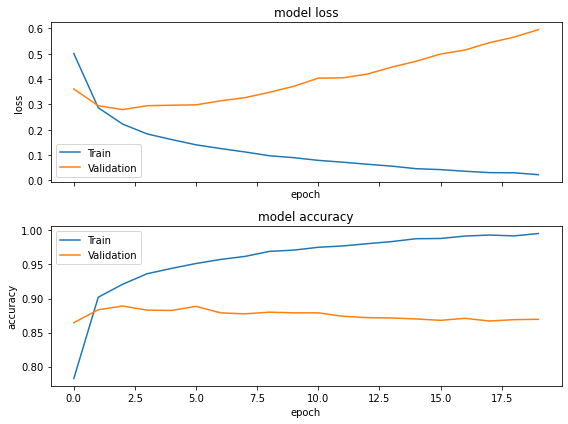

In [63]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize=(8,6))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['Train', 'Validation'])

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['Train', 'Validation'])

plt.tight_layout();

In [64]:
history2 = model.fit(x = x_train_1h.tocsr()[~ival_mask], 
                     y = y_train[~ival_mask], 
                     epochs=20, batch_size=512, 
                     validation_data=(x_test_1h.tocsr(), y_test)
                    )

Epoch 1/20
45/45 [==============================] - 1s 18ms/step - loss: 0.0198 - accuracy: 0.9954 - val_loss: 0.7299 - val_accuracy: 0.8521
Epoch 2/20
45/45 [==============================] - 1s 22ms/step - loss: 0.0168 - accuracy: 0.9963 - val_loss: 0.7041 - val_accuracy: 0.8565
Epoch 3/20
45/45 [==============================] - 1s 20ms/step - loss: 0.0153 - accuracy: 0.9965 - val_loss: 0.7366 - val_accuracy: 0.8556
Epoch 4/20
45/45 [==============================] - 1s 17ms/step - loss: 0.0138 - accuracy: 0.9969 - val_loss: 0.7619 - val_accuracy: 0.8548
Epoch 5/20
45/45 [==============================] - 1s 13ms/step - loss: 0.0130 - accuracy: 0.9968 - val_loss: 0.7914 - val_accuracy: 0.8556
Epoch 6/20
45/45 [==============================] - 1s 15ms/step - loss: 0.0124 - accuracy: 0.9967 - val_loss: 0.8184 - val_accuracy: 0.8544
Epoch 7/20
45/45 [==============================] - 1s 13ms/step - loss: 0.0044 - accuracy: 0.9997 - val_loss: 0.8884 - val_accuracy: 0.8506
Epoch 8/20
45

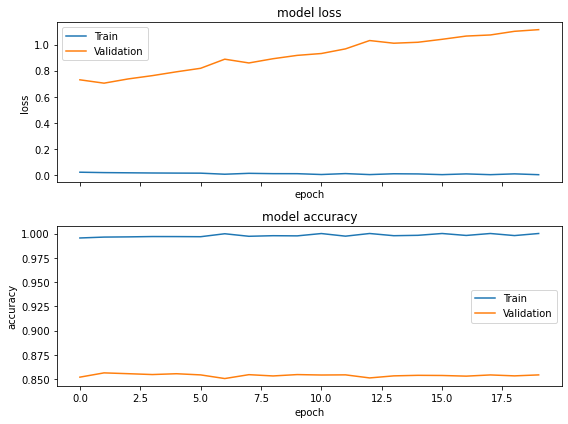

In [65]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize=(8,6))

ax[0].plot(history2.history['loss'])
ax[0].plot(history2.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['Train', 'Validation'])

ax[1].plot(history2.history['accuracy'])
ax[1].plot(history2.history['val_accuracy'])
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['Train', 'Validation'])

plt.tight_layout();

# 10.9.6 Recurrent Neural Networks

In [66]:
max_features = 10_000
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)

In [67]:
wc = []
for seq in x_train:
    seq_len = len(seq)
    wc.append(seq_len)
    
wc = np.array(wc)

np.median(wc)

178.0

In [68]:
sum(wc <= 500) / len(wc)

0.91568

In [69]:
maxlen = 500
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)

In [70]:
def pad_sequences(data, maxlen):

    padded = []

    for row in data:
        row_len = len(row)
        abs_diff = abs(maxlen - row_len)
        if row_len < maxlen:
            padded.append(np.pad(array=row, pad_width=(abs_diff, 0)))
        else:
            padded.append(np.array(row[abs_diff:]))
           
    padded_array = np.array(padded)
    
    return padded_array

In [71]:
x_train = pad_sequences(x_train, maxlen)
x_test = pad_sequences(x_test, maxlen)

x_train.shape

(25000, 500)

In [72]:
x_test.shape

(25000, 500)

In [73]:
x_train[0, 489:500]

array([  16, 4472,  113,  103,   32,   15,   16, 5345,   19,  178,   32])

In [74]:
model = keras.models.Sequential(
    [
        layers.Embedding(input_dim = 10000, output_dim = 32),
        layers.LSTM(units = 32),
        layers.Dense(units = 1, activation = 'sigmoid')
    ]
)

In [75]:
model.compile(optimizer = 'rmsprop', loss='binary_crossentropy', metrics='accuracy')

history = model.fit(x = x_train, 
                    y = y_train,
                    epochs = 10, batch_size = 128,
                    validation_data = (x_test, y_test)
                   )

Epoch 1/10
196/196 [==============================] - 41s 199ms/step - loss: 0.5543 - accuracy: 0.7078 - val_loss: 0.9144 - val_accuracy: 0.6172
Epoch 2/10
196/196 [==============================] - 38s 194ms/step - loss: 0.3276 - accuracy: 0.8667 - val_loss: 0.3240 - val_accuracy: 0.8679
Epoch 3/10
196/196 [==============================] - 39s 199ms/step - loss: 0.2601 - accuracy: 0.8986 - val_loss: 0.3012 - val_accuracy: 0.8757
Epoch 4/10
196/196 [==============================] - 39s 200ms/step - loss: 0.2271 - accuracy: 0.9136 - val_loss: 0.3068 - val_accuracy: 0.8748
Epoch 5/10
196/196 [==============================] - 38s 196ms/step - loss: 0.2015 - accuracy: 0.9271 - val_loss: 0.3185 - val_accuracy: 0.8746
Epoch 6/10
196/196 [==============================] - 39s 200ms/step - loss: 0.1852 - accuracy: 0.9322 - val_loss: 0.2990 - val_accuracy: 0.8777
Epoch 7/10
196/196 [==============================] - 39s 201ms/step - loss: 0.1644 - accuracy: 0.9414 - val_loss: 0.3378 - val_ac

782/782 [==============================] - 19s 24ms/step


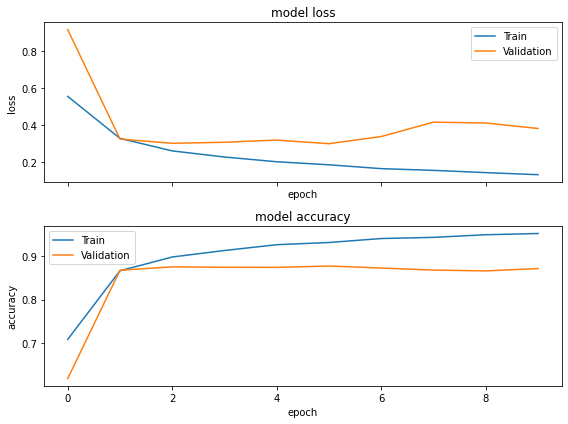

In [76]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize = (8,6))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['Train', 'Validation'])

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['Train', 'Validation'])

plt.tight_layout()

predy = model.predict(x_test) > 0.5

np.mean(y_test == predy.flatten());

## Time Series Prediction

In [77]:
data = robjects.r("""
library(ISLR2)
xdata <- NYSE[, c("DJ_return", "log_volume", "log_volatility")]
""")
with localconverter(robjects.default_converter + pandas2ri.converter):
    xdata = robjects.conversion.rpy2py(data)
    
data = robjects.r("""
library(ISLR2)
xdata <- NYSE[, "train"]
""")
istrain = np.array(data)

xdata = (xdata - xdata.mean()) / xdata.std()

In [78]:
def lagm(df, prefix, k=1):
    num_rows, num_cols = df.shape
    
    null_df = pd.DataFrame(np.ones(shape=(k, num_cols)) * np.nan,
                           columns = df.columns)
    
    padded_df = pd.concat([null_df, df[:-k]], ignore_index=True)
    #padded_df.index += 1
    
    for column in padded_df.columns:
        padded_df = padded_df.rename(columns={column: prefix + '_' + column})
    
    return padded_df

In [79]:
arframe = pd.concat(
    [
        xdata[['log_volume']].reset_index(drop=True),
        lagm(xdata, 'L1', 1), 
        lagm(xdata, 'L2', 2),
        lagm(xdata, 'L3', 3),
        lagm(xdata, 'L4', 4),
        lagm(xdata, 'L5', 5)
    ], axis=1
)

In [80]:
arframe = arframe[5:]
istrain = istrain[5:]

In [81]:
training_mask = istrain.astype(bool)

formula_string = formula_from_cols(arframe, 'log_volume')

armodel = smf.ols(formula=formula_string, data = sm.add_constant(arframe[training_mask]))

arfit = armodel.fit()

arpred = arfit.predict(arframe[~training_mask])
V_0 = arframe[~training_mask]['log_volume'].var()
1 - np.mean((arpred - arframe[~training_mask]['log_volume'])**2) / V_0

0.41322299369023163

In [82]:
data = robjects.r("""
library(ISLR2)
xdata <- NYSE[, 'day_of_week']
""")
day_df = pd.DataFrame(np.array(data), columns=['day'])

arframed = pd.concat([day_df[5:], arframe], axis=1)

formula_string = formula_from_cols(arframed, 'log_volume')

armodeld = smf.ols(formula=formula_string, data = sm.add_constant(arframed[training_mask]))

arfitd = armodeld.fit()

arpredd = arfitd.predict(arframed[~training_mask])
1 - np.mean((arpredd - arframed[~training_mask]['log_volume']) ** 2) / V_0

0.459861648721539

In [83]:
n = arframe.shape[0]
xrnn = pd.DataFrame(arframe.iloc[:,1:])
xrnn = np.array(xrnn)
xrnn = xrnn.reshape((n, 3, 5), order='F')
xrnn = xrnn[:,:,::-1]
xrnn = xrnn.transpose((0,2,1))
xrnn.shape

(6046, 5, 3)

In [84]:
model = keras.models.Sequential(
    [
        layers.SimpleRNN(units=12,
                         dropout=0.1,
                         recurrent_dropout=0.1),
        layers.Dense(units=1)
    ]
)

model.compile(optimizer='rmsprop', loss='mse')

In [85]:
history = model.fit(
    x = xrnn[training_mask, :, :],
    y = arframe[training_mask]['log_volume'],
    batch_size = 64, epochs = 200,
    validation_data = (xrnn[~training_mask, :, :], 
                       arframe[~training_mask]['log_volume'])
)

kpred = model.predict(xrnn[~training_mask])
1 - np.mean((kpred.flatten() - arframe[~training_mask]['log_volume'])**2) / V_0

Epoch 1/200
67/67 [==============================] - 1s 5ms/step - loss: 0.7863 - val_loss: 0.7196
Epoch 2/200
67/67 [==============================] - 0s 2ms/step - loss: 0.5514 - val_loss: 0.6796
Epoch 3/200
67/67 [==============================] - 0s 2ms/step - loss: 0.5139 - val_loss: 0.6690
Epoch 4/200
67/67 [==============================] - 0s 3ms/step - loss: 0.5012 - val_loss: 0.6613
Epoch 5/200
67/67 [==============================] - 0s 2ms/step - loss: 0.5000 - val_loss: 0.6619
Epoch 6/200
67/67 [==============================] - 0s 2ms/step - loss: 0.4937 - val_loss: 0.6613
Epoch 7/200
67/67 [==============================] - 0s 2ms/step - loss: 0.4826 - val_loss: 0.6554
Epoch 8/200
67/67 [==============================] - 0s 2ms/step - loss: 0.4830 - val_loss: 0.6616
Epoch 9/200
67/67 [==============================] - 0s 2ms/step - loss: 0.4781 - val_loss: 0.6515
Epoch 10/200
67/67 [==============================] - 0s 2ms/step - loss: 0.4831 - val_loss: 0.6540
Epoch 11/

0.4121687219278033

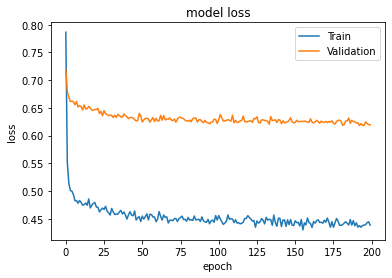

In [86]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation']);

In [87]:
model = keras.models.Sequential(
    [
        layers.Flatten(),
        layers.Dense(units = 1)
    ]
)

model.compile(optimizer='rmsprop', loss='mse')

In [88]:
history = model.fit(
    x = xrnn[training_mask, :, :],
    y = arframe[training_mask]['log_volume'],
    batch_size = 64, epochs = 200,
    validation_data = (xrnn[~training_mask, :, :], 
                       arframe[~training_mask]['log_volume'])
)

kpred = model.predict(xrnn[~training_mask])
1 - np.mean((kpred.flatten() - arframe[~training_mask]['log_volume'])**2) / V_0

Epoch 1/200
67/67 [==============================] - 0s 3ms/step - loss: 1.0030 - val_loss: 1.2790
Epoch 2/200
67/67 [==============================] - 0s 1ms/step - loss: 0.8497 - val_loss: 1.1144
Epoch 3/200
67/67 [==============================] - 0s 1ms/step - loss: 0.7359 - val_loss: 0.9852
Epoch 4/200
67/67 [==============================] - 0s 1ms/step - loss: 0.6473 - val_loss: 0.8807
Epoch 5/200
67/67 [==============================] - 0s 1ms/step - loss: 0.5826 - val_loss: 0.8075
Epoch 6/200
67/67 [==============================] - 0s 1ms/step - loss: 0.5354 - val_loss: 0.7519
Epoch 7/200
67/67 [==============================] - 0s 1ms/step - loss: 0.5037 - val_loss: 0.7133
Epoch 8/200
67/67 [==============================] - 0s 1ms/step - loss: 0.4826 - val_loss: 0.6889
Epoch 9/200
67/67 [==============================] - 0s 1ms/step - loss: 0.4702 - val_loss: 0.6759
Epoch 10/200
67/67 [==============================] - 0s 1ms/step - loss: 0.4633 - val_loss: 0.6677
Epoch 11/

0.41294648740996276

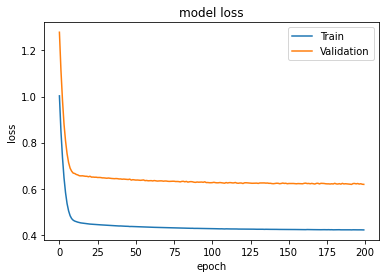

In [89]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation']);

In [90]:
x = patsy.dmatrix(formula_like = 'day + L1_DJ_return + L1_log_volume + L1_log_volatility + L2_DJ_return + L2_log_volume + L2_log_volatility + L3_DJ_return + L3_log_volume + L3_log_volatility + L4_DJ_return + L4_log_volume + L4_log_volatility + L5_DJ_return + L5_log_volume + L5_log_volatility - 1', data = arframed)

x.design_info.column_names

['day[fri]',
 'day[mon]',
 'day[thur]',
 'day[tues]',
 'day[wed]',
 'L1_DJ_return',
 'L1_log_volume',
 'L1_log_volatility',
 'L2_DJ_return',
 'L2_log_volume',
 'L2_log_volatility',
 'L3_DJ_return',
 'L3_log_volume',
 'L3_log_volatility',
 'L4_DJ_return',
 'L4_log_volume',
 'L4_log_volatility',
 'L5_DJ_return',
 'L5_log_volume',
 'L5_log_volatility']

In [91]:
arnnd = keras.models.Sequential(
    [
        layers.Dense(units = 32, activation = 'relu'),
        layers.Dropout(rate = 0.5),
        layers.Dense(units = 1)
    ]
)

arnnd.compile(loss = 'mse', optimizer = 'rmsprop')

history = arnnd.fit(
    x = x[training_mask],
    y = arframe[training_mask]['log_volume'],
    epochs = 100, batch_size = 32, 
    validation_data = [x[~training_mask], arframe[~training_mask]['log_volume']]
)

npred = arnnd.predict(x[~training_mask])
1 - np.mean((arframe[~training_mask]['log_volume'] - npred.flatten())**2) / V_0

Epoch 1/100
134/134 [==============================] - 1s 2ms/step - loss: 1.0399 - val_loss: 0.7219
Epoch 2/100
134/134 [==============================] - 0s 1ms/step - loss: 0.6629 - val_loss: 0.6433
Epoch 3/100
134/134 [==============================] - 0s 1ms/step - loss: 0.5718 - val_loss: 0.6070
Epoch 4/100
134/134 [==============================] - 0s 1ms/step - loss: 0.5166 - val_loss: 0.5921
Epoch 5/100
134/134 [==============================] - 0s 1ms/step - loss: 0.4898 - val_loss: 0.5838
Epoch 6/100
134/134 [==============================] - 0s 1ms/step - loss: 0.4859 - val_loss: 0.5808
Epoch 7/100
134/134 [==============================] - 0s 1ms/step - loss: 0.4727 - val_loss: 0.5751
Epoch 8/100
134/134 [==============================] - 0s 1ms/step - loss: 0.4606 - val_loss: 0.5749
Epoch 9/100
134/134 [==============================] - 0s 1ms/step - loss: 0.4636 - val_loss: 0.5733
Epoch 10/100
134/134 [==============================] - 0s 1ms/step - loss: 0.4499 - val_lo

0.46813374704335686

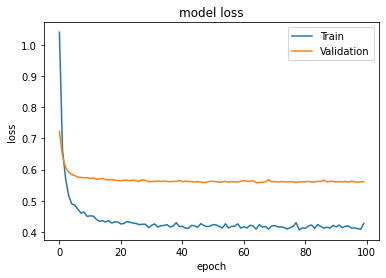

In [92]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation']);

The End